In [12]:
import os
import cv2
import numpy as np
import face_recognition
from gender_detection import f_my_gender
from emotion_detection import f_emotion_detection
import tensorflow as tf
from tensorflow.keras.utils import load_img
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input
import random
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import pandas as pd
from PIL import Image
from tensorflow.keras.utils import plot_model
import warnings
from tqdm.notebook import tqdm
from keras.preprocessing.image import load_img, img_to_array
from tqdm import tqdm
warnings.filterwarnings('ignore')
%matplotlib inline




In [31]:
BASE_DIR = '/Users/khalifa/Desktop/Face_info-master/UTKFace-All-Gneder'
age_labels = []
gender_labels = []
image_paths = []

image_filenames = os.listdir(BASE_DIR)
random.shuffle(image_filenames)

for image in tqdm(image_filenames):
  image_path = os.path.join(BASE_DIR, image)
  img_components = image.split('_')
  age_label = int(img_components[0])
  gender_label = int(img_components[1])

  # Append the image_path, age_label, and gender_label
  age_labels.append(age_label)
  gender_labels.append(gender_label)
  image_paths.append(image_path)





100%|██████████| 23708/23708 [00:00<00:00, 1116246.19it/s]


In [3]:
print(f'Number of age_labels: {len(age_labels)}, Number of gender_labels: {len(gender_labels)}, Number of image_paths: {len(image_paths)}')

Number of age_labels: 23708, Number of gender_labels: 23708, Number of image_paths: 23708


In [4]:
gender_mapping = {
    1: 'Female',
    0: 'Male'
}

In [5]:
import pandas as pd
df = pd.DataFrame()
df['image_path'], df['age'], df['gender'] = image_paths, age_labels, gender_labels
df.head(5)

,image_path,age,gender
0,/Users/khalifa/Desktop/Face_info-master/UTKFac...,37,0
1,/Users/khalifa/Desktop/Face_info-master/UTKFac...,28,1
2,/Users/khalifa/Desktop/Face_info-master/UTKFac...,56,0
3,/Users/khalifa/Desktop/Face_info-master/UTKFac...,26,1
4,/Users/khalifa/Desktop/Face_info-master/UTKFac...,25,0


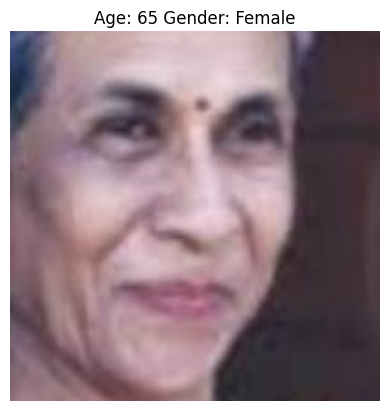

In [6]:
from PIL import Image

rand_index = random.randint(0, len(image_paths))
age = df['age'][rand_index]
gender = df['gender'][rand_index]
IMG = Image.open(df['image_path'][rand_index])
plt.title(f'Age: {age} Gender: {gender_mapping[gender]}')
plt.axis('off')
plt.imshow(IMG)

<Axes: xlabel='age', ylabel='Density'>

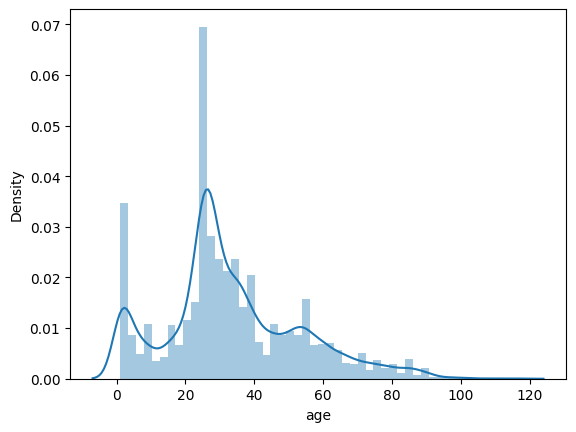

In [7]:
 # Age distribution
 sns.distplot(df['age'])

<Axes: ylabel='count'>

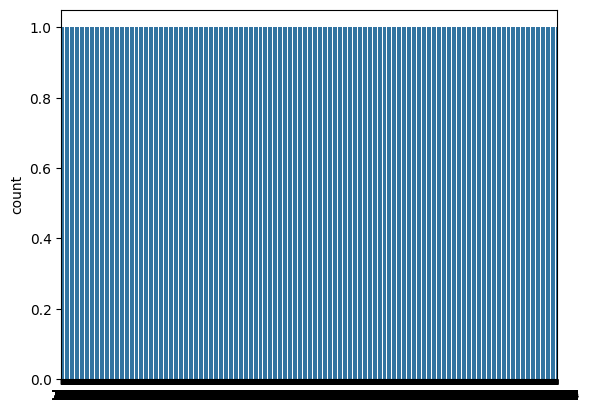

In [8]:
sns.countplot(df['gender'])

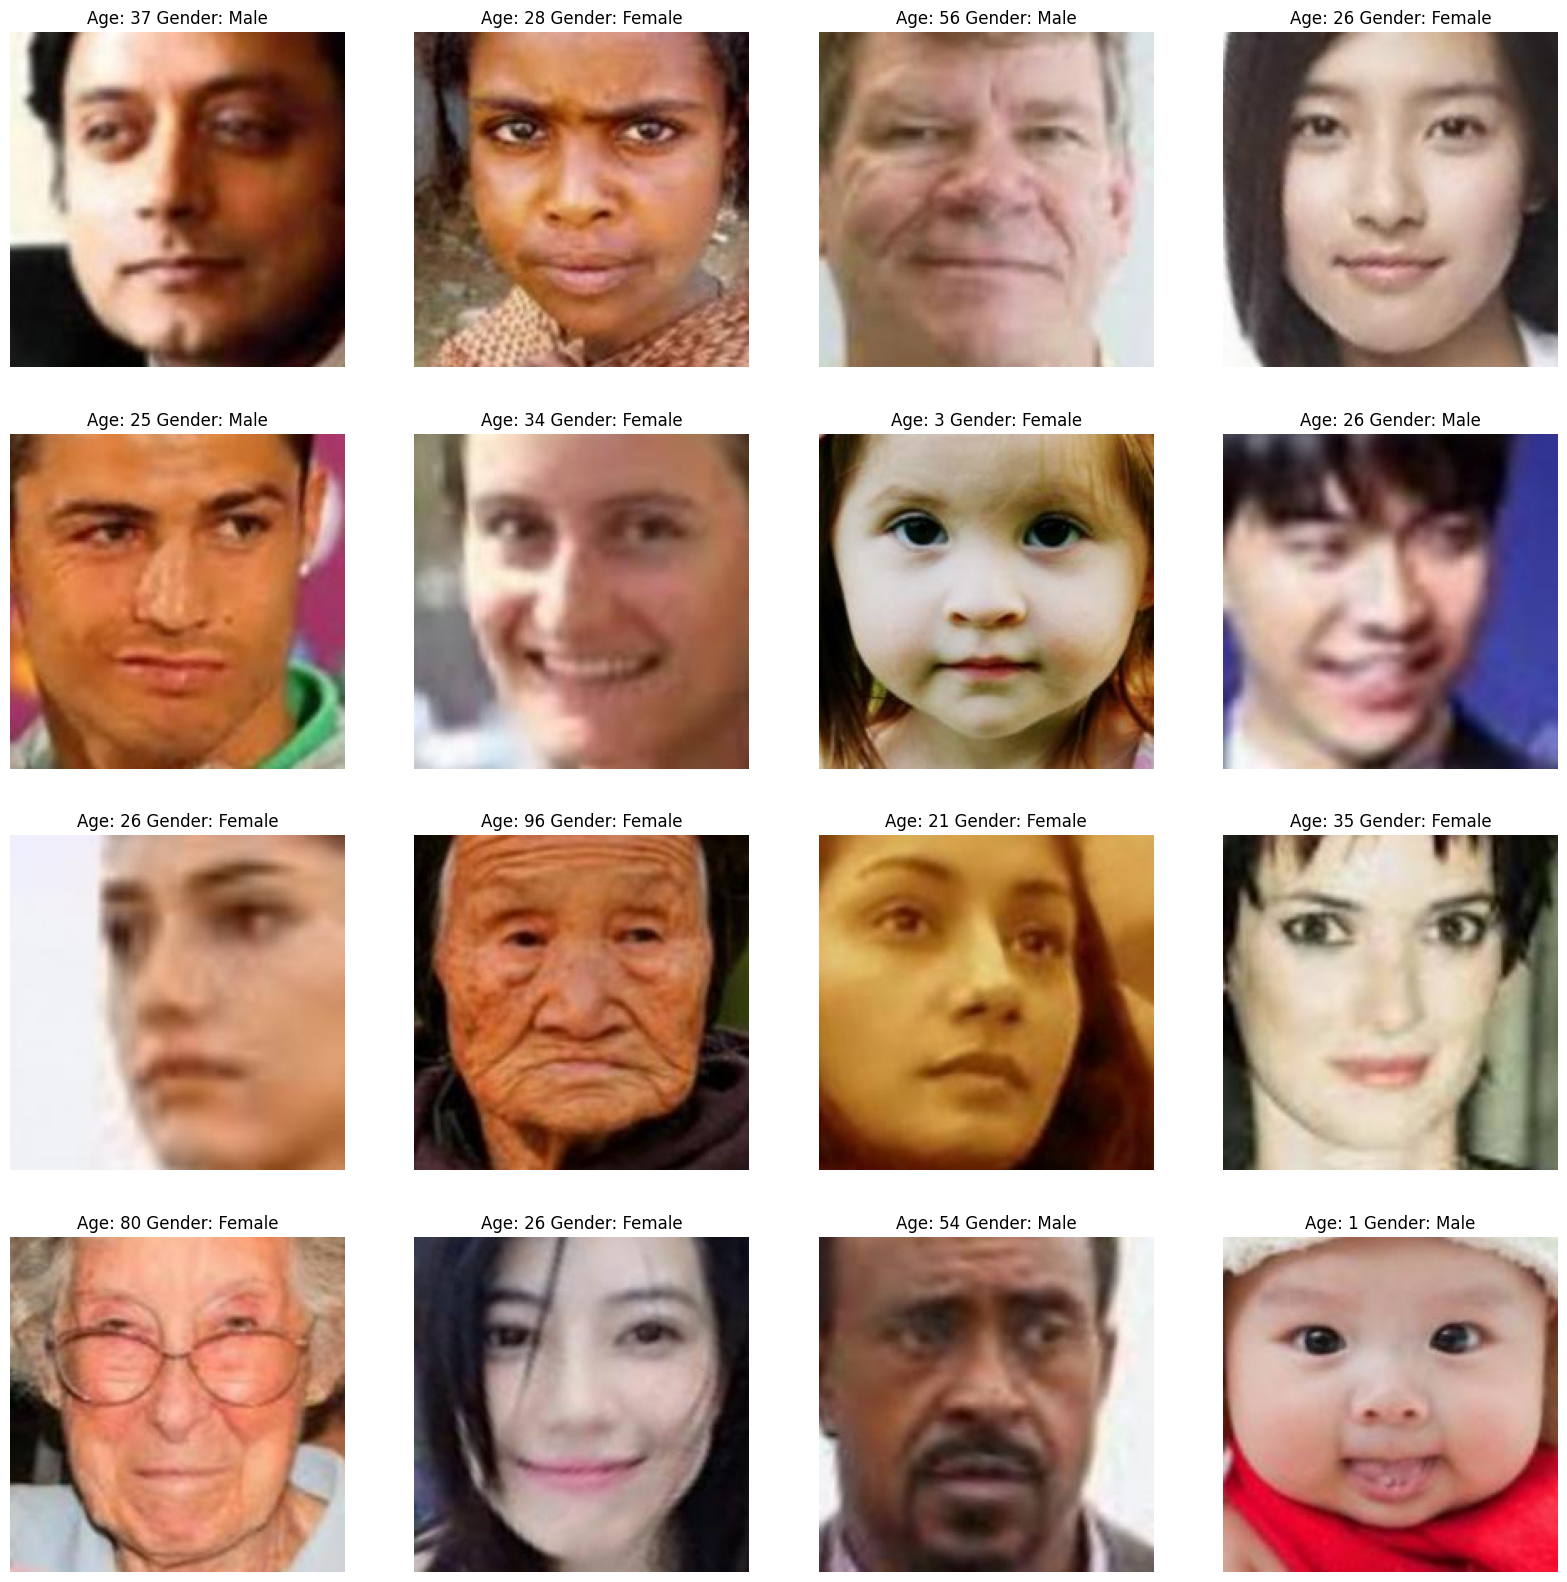

In [9]:
plt.figure(figsize=(20, 20))
samples = df.iloc[0:16]

for index, sample, age, gender in samples.itertuples():
    plt.subplot(4, 4, index + 1)
    img = load_img(sample)
    img = np.array(img)
    plt.axis('off')
    plt.title(f'Age: {age} Gender: {gender_mapping[gender]}')
    plt.imshow(img)

In [45]:
def extract_image_features(images):
    features = list()

    for image in tqdm(images):
        img = load_img(image, grayscale=True)
        img = img.resize((128, 128), Image.ANTIALIAS)
        img = np.array(img)
        features.append(img)

    features = np.array(features)
    features = features.reshape(len(features), 128, 128, 1)
    return features

In [48]:
X = extract_image_features(df['image_path'])


  0%|          | 0/23708 [00:00<?, ?it/s]


AttributeError: module 'PIL.Image' has no attribute 'ANTIALIAS'

In [34]:
X.shape

(23708, 128, 128, 1)

In [35]:
X = X / 255.0

In [36]:
y_gender = np.array(df['gender'])
y_age = np.array(df['age'])

In [37]:
input_shape = (128, 128, 1)

In [38]:
inputs = Input((input_shape))
conv_1 = Conv2D(32, kernel_size=(3, 3), activation='relu')(inputs)
max_1 = MaxPooling2D(pool_size=(2, 2))(conv_1)
conv_2 = Conv2D(64, kernel_size=(3, 3), activation='relu')(max_1)
max_2 = MaxPooling2D(pool_size=(2, 2))(conv_2)
conv_3 = Conv2D(128, kernel_size=(3, 3), activation='relu')(max_2)
max_3 = MaxPooling2D(pool_size=(2, 2))(conv_3)
conv_4 = Conv2D(256, kernel_size=(3, 3), activation='relu')(max_3)
max_4 = MaxPooling2D(pool_size=(2, 2))(conv_4)

flatten = Flatten()(max_4)

# fully connected layers
dense_1 = Dense(256, activation='relu')(flatten)
dense_2 = Dense(256, activation='relu')(flatten)

dropout_1 = Dropout(0.3)(dense_1)
dropout_2 = Dropout(0.3)(dense_2)

output_1 = Dense(1, activation='sigmoid', name='gender_out')(dropout_1)
output_2 = Dense(1, activation='relu', name='age_out')(dropout_2)

model = Model(inputs=[inputs], outputs=[output_1, output_2])

model.compile(loss=['binary_crossentropy', 'mae'],
              optimizer='adam', metrics=['accuracy'])

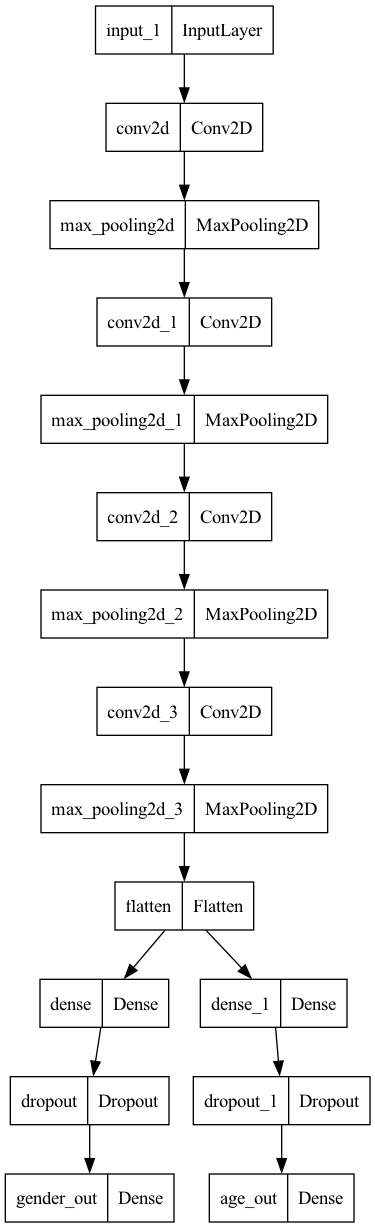

In [39]:
# plot the model
from tensorflow.keras.utils import plot_model
plot_model(model)

In [42]:
history = model.fit(x=X, y=[y_gender, y_age],
                    batch_size=32, epochs=50, validation_split=0.2)

Epoch 1/50
593/593 [==============================] - 186s 313ms/step - loss: 16.1105 - gender_out_loss: 0.6922 - age_out_loss: 15.4183 - gender_out_accuracy: 0.5229 - age_out_accuracy: 0.0478 - val_loss: 15.6560 - val_gender_out_loss: 0.6922 - val_age_out_loss: 14.9638 - val_gender_out_accuracy: 0.5217 - val_age_out_accuracy: 0.0456
Epoch 2/50
 33/593 [>.............................] - ETA: 2:24 - loss: 15.4508 - gender_out_loss: 0.6937 - age_out_loss: 14.7571 - gender_out_accuracy: 0.4981 - age_out_accuracy: 0.0312

KeyboardInterrupt: 